# Code to compare episodic reward for sample efficiency

In [52]:
from pathlib import Path
import re

import scope
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid", font_scale=1.5, palette="Set2")
plt.rcParams['figure.dpi'] = 300

## Function Definitions

In [53]:
_STEP_REGEX   = re.compile(r"\b(step|timestep|steps|total_steps|global_step)\b", re.I)

def _read_float_file(path: Path, value_col: str):
    reader = scope.Reader(path)
    steps, values = reader[value_col]
    return np.asarray(steps), np.asarray(values)

def _read_log(path: Path, value_col: str, value_name: str) -> pd.DataFrame:
    """Load *path* and return a DataFrame with columns [step, reward]."""

    if path.suffix.lower() in {".csv", ".txt"}:
        df = pd.read_csv(path)
    elif path.suffix.lower() == ".jsonl" or path.suffix.lower() == ".json":
        df = pd.read_json(path, lines=True)
    else:
        s, v = _read_float_file(path, value_col)
        df = pd.DataFrame(
            {
                "step": s,
                value_col: v
            }
        )

    # Auto-detect columns if none supplied
    step_col = next((c for c in df.columns if _STEP_REGEX.search(c)), None)

    if step_col is None:
        raise ValueError(
            f"{path}: couldn’t find both a step-like and reward/score-like column.\n"
            "Use --step-col and/or --reward-col to specify them."
        )

    return df[[step_col, value_col]].rename(columns={step_col: "step",
                                                      value_col: value_name})

def _bin(df: pd.DataFrame, bin_size: int = 1, value_name: str = "reward") -> pd.DataFrame:
    if bin_size == 1:
        return df.rename(columns={"step": "step_mid"})   # identity

    bins = range(0, df["step"].max() + bin_size, bin_size)
    df_binned = (df
                .groupby(pd.cut(df["step"], bins))
                [value_name]
                .mean()
                .reset_index())
    df_binned["step_mid"] = df_binned["step"].apply(lambda iv: iv.mid)
    return df_binned

def plot(files_labels=[], bin_size=1, output=None, value_col="reward", value_name="reward", xlabel="Environment steps", ylabel="Episodic reward", title="RL Learning Curves"):
    plt.figure(figsize=(10, 6))

    for path, label in files_labels:
        df = _read_log(Path(path), value_col=value_col, value_name=value_name)
        df_binned = _bin(df, bin_size=bin_size, value_name=value_name)  # Bin the data for better visualization
        sns.lineplot(x=df_binned["step_mid"], y=df_binned[value_name], errorbar='se', label=label, linewidth=1.3)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (Bin Size: {bin_size})")
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")


def plot_with_uncertainty(
    files_labels_groups,
    bin_size=1,
    value_col="reward",
    value_name="reward",
    xlabel="Environment steps",
    ylabel="Episodic reward",
    title="RL Learning Curves"
):
    plt.figure(figsize=(10, 6))
    for group in files_labels_groups:
        files = group["files"]
        label = group["label"]
        dfs = []
        for f in files:
            df = _read_log(Path(f), value_col=value_col, value_name=value_name)
            df_binned = _bin(df, bin_size=bin_size, value_name=value_name)
            dfs.append(df_binned)
        df_all = pd.concat(dfs, keys=range(len(dfs)), names=["run"])
        df_grouped = df_all.groupby("step_mid")[value_name]
        mean = df_grouped.mean()
        std = df_grouped.std()
        plt.plot(mean.index, mean.values, label=label)
        plt.fill_between(mean.index, mean - std, mean + std, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (Bin Size: {bin_size})")
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_with_uncertainty_interp(
    files_labels_groups,
    window=20,
    max_step=None,
    step_interval=1000,
    value_col="reward",
    value_name="reward",
    xlabel="Environment steps",
    ylabel="Episodic reward",
    title="RL Learning Curves"
):
    plt.figure(figsize=(10, 6))
    for group in files_labels_groups:
        files = group["files"]
        label = group["label"]
        runs = []

        if max_step is not None:
            fixed_max_step = True
        else:
            fixed_max_step = False
            max_step = 0
            
        # Collect all runs and find max step
        for f in files:
            df = _read_log(Path(f), value_col=value_col, value_name=value_name)
            df = df.sort_values("step")
            steps = df["step"].to_numpy()
            scores = df[value_name].to_numpy()
            runs.append((steps, scores))
            if not fixed_max_step and (steps[-1] > max_step):
                max_step = steps[-1]
        # Define common step grid
        common_steps = np.arange(0, max_step + step_interval, step_interval)
        all_runs_interp = []
        for steps, scores in runs:
            interp = np.interp(common_steps, steps, scores)
            all_runs_interp.append(interp)

        arr = np.stack(all_runs_interp, axis=0)
        mean_curve = arr.mean(axis=0)
        std_curve = arr.std(axis=0)

        mean_curve = pd.Series(mean_curve).rolling(window=window, center=True, min_periods=1).mean().to_numpy()
        std_curve = pd.Series(std_curve).rolling(window=window, center=True, min_periods=1).mean().to_numpy()
        plt.plot(common_steps, mean_curve, label=label)
        plt.fill_between(common_steps, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (Window: {window}, Step: {step_interval})")
    plt.grid(alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    plt.show()

## Plots

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_59098/950051003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_59098/950051003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_59098/950051003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

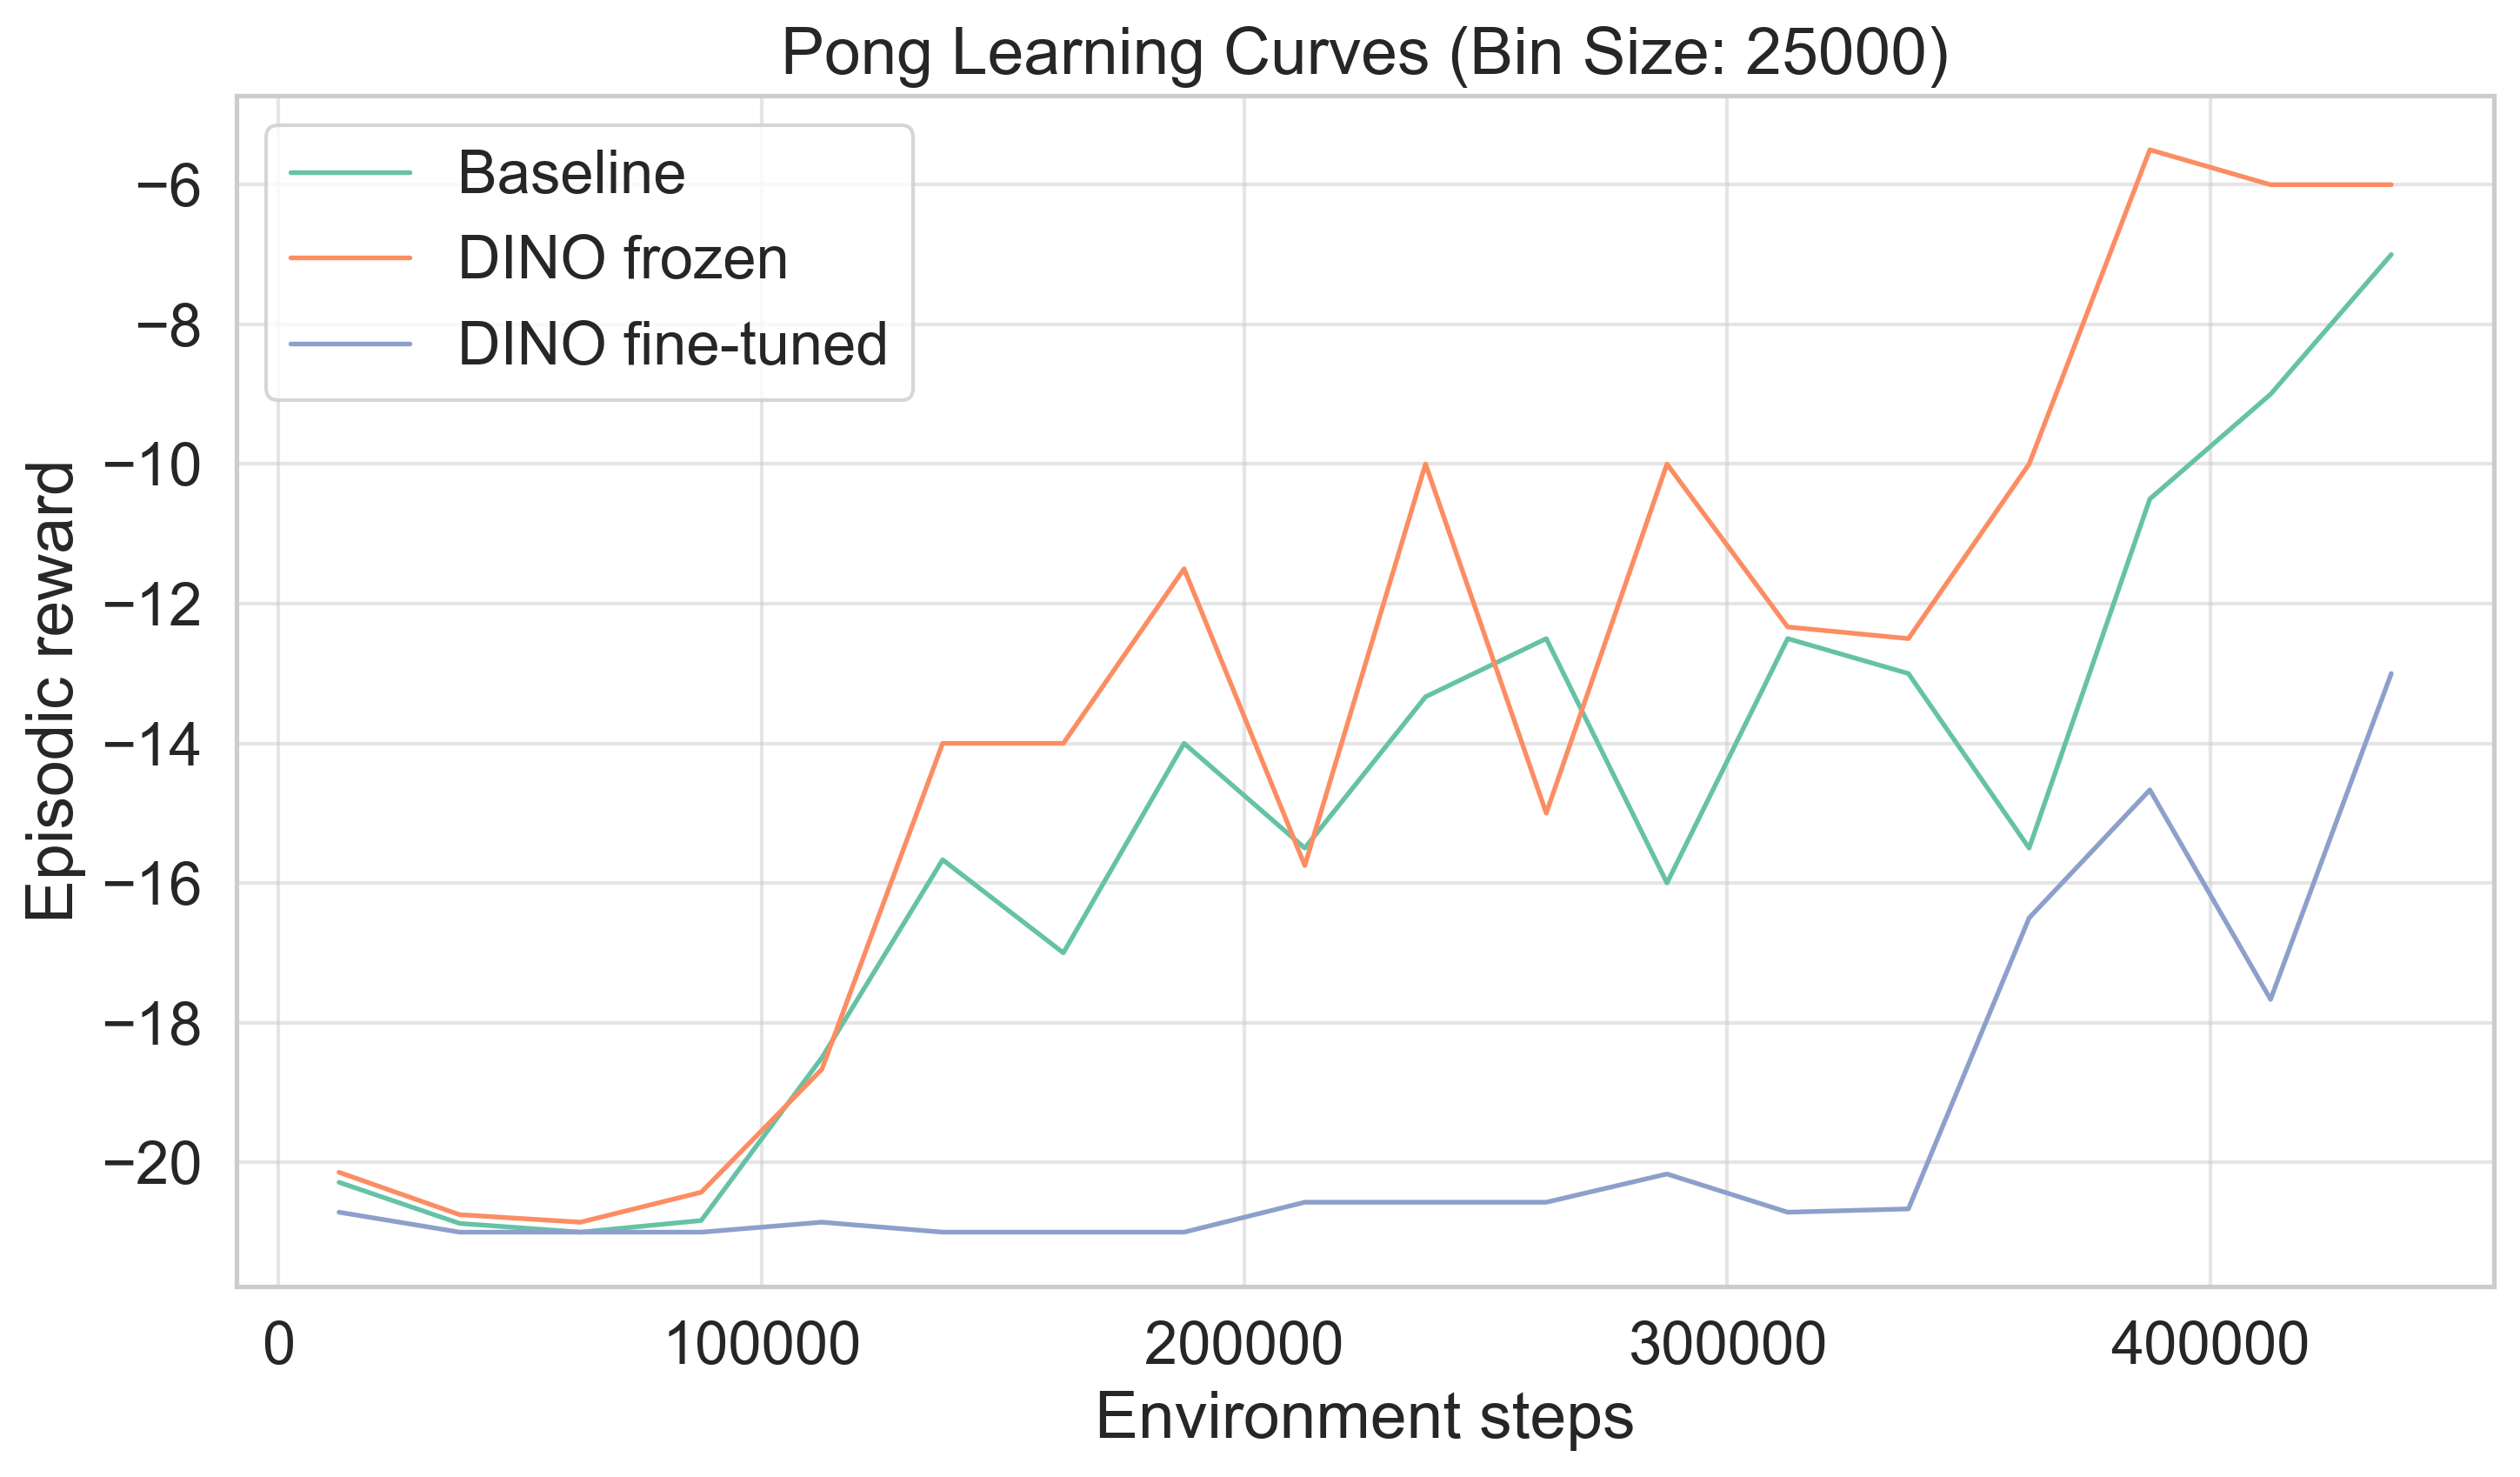

In [ ]:
plot(
    files_labels=[
        ("./logdir/pong/pong_baseline/scores.jsonl", "Baseline"),
        ("./logdir/pong/pong_DINO_frozen/scores.jsonl", "DINO frozen"),
        ("./logdir/pong/pong_DINO_ft/scores.jsonl", "DINO fine-tuned"),
    ],
    bin_size=25000,
    value_col="episode/score",
    value_name="reward",
    xlabel="Environment steps",
    ylabel="Episodic reward",
    title="Pong Learning Curves",
)

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_71211/2185395455.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_71211/2185395455.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_71211/2185395455.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future def

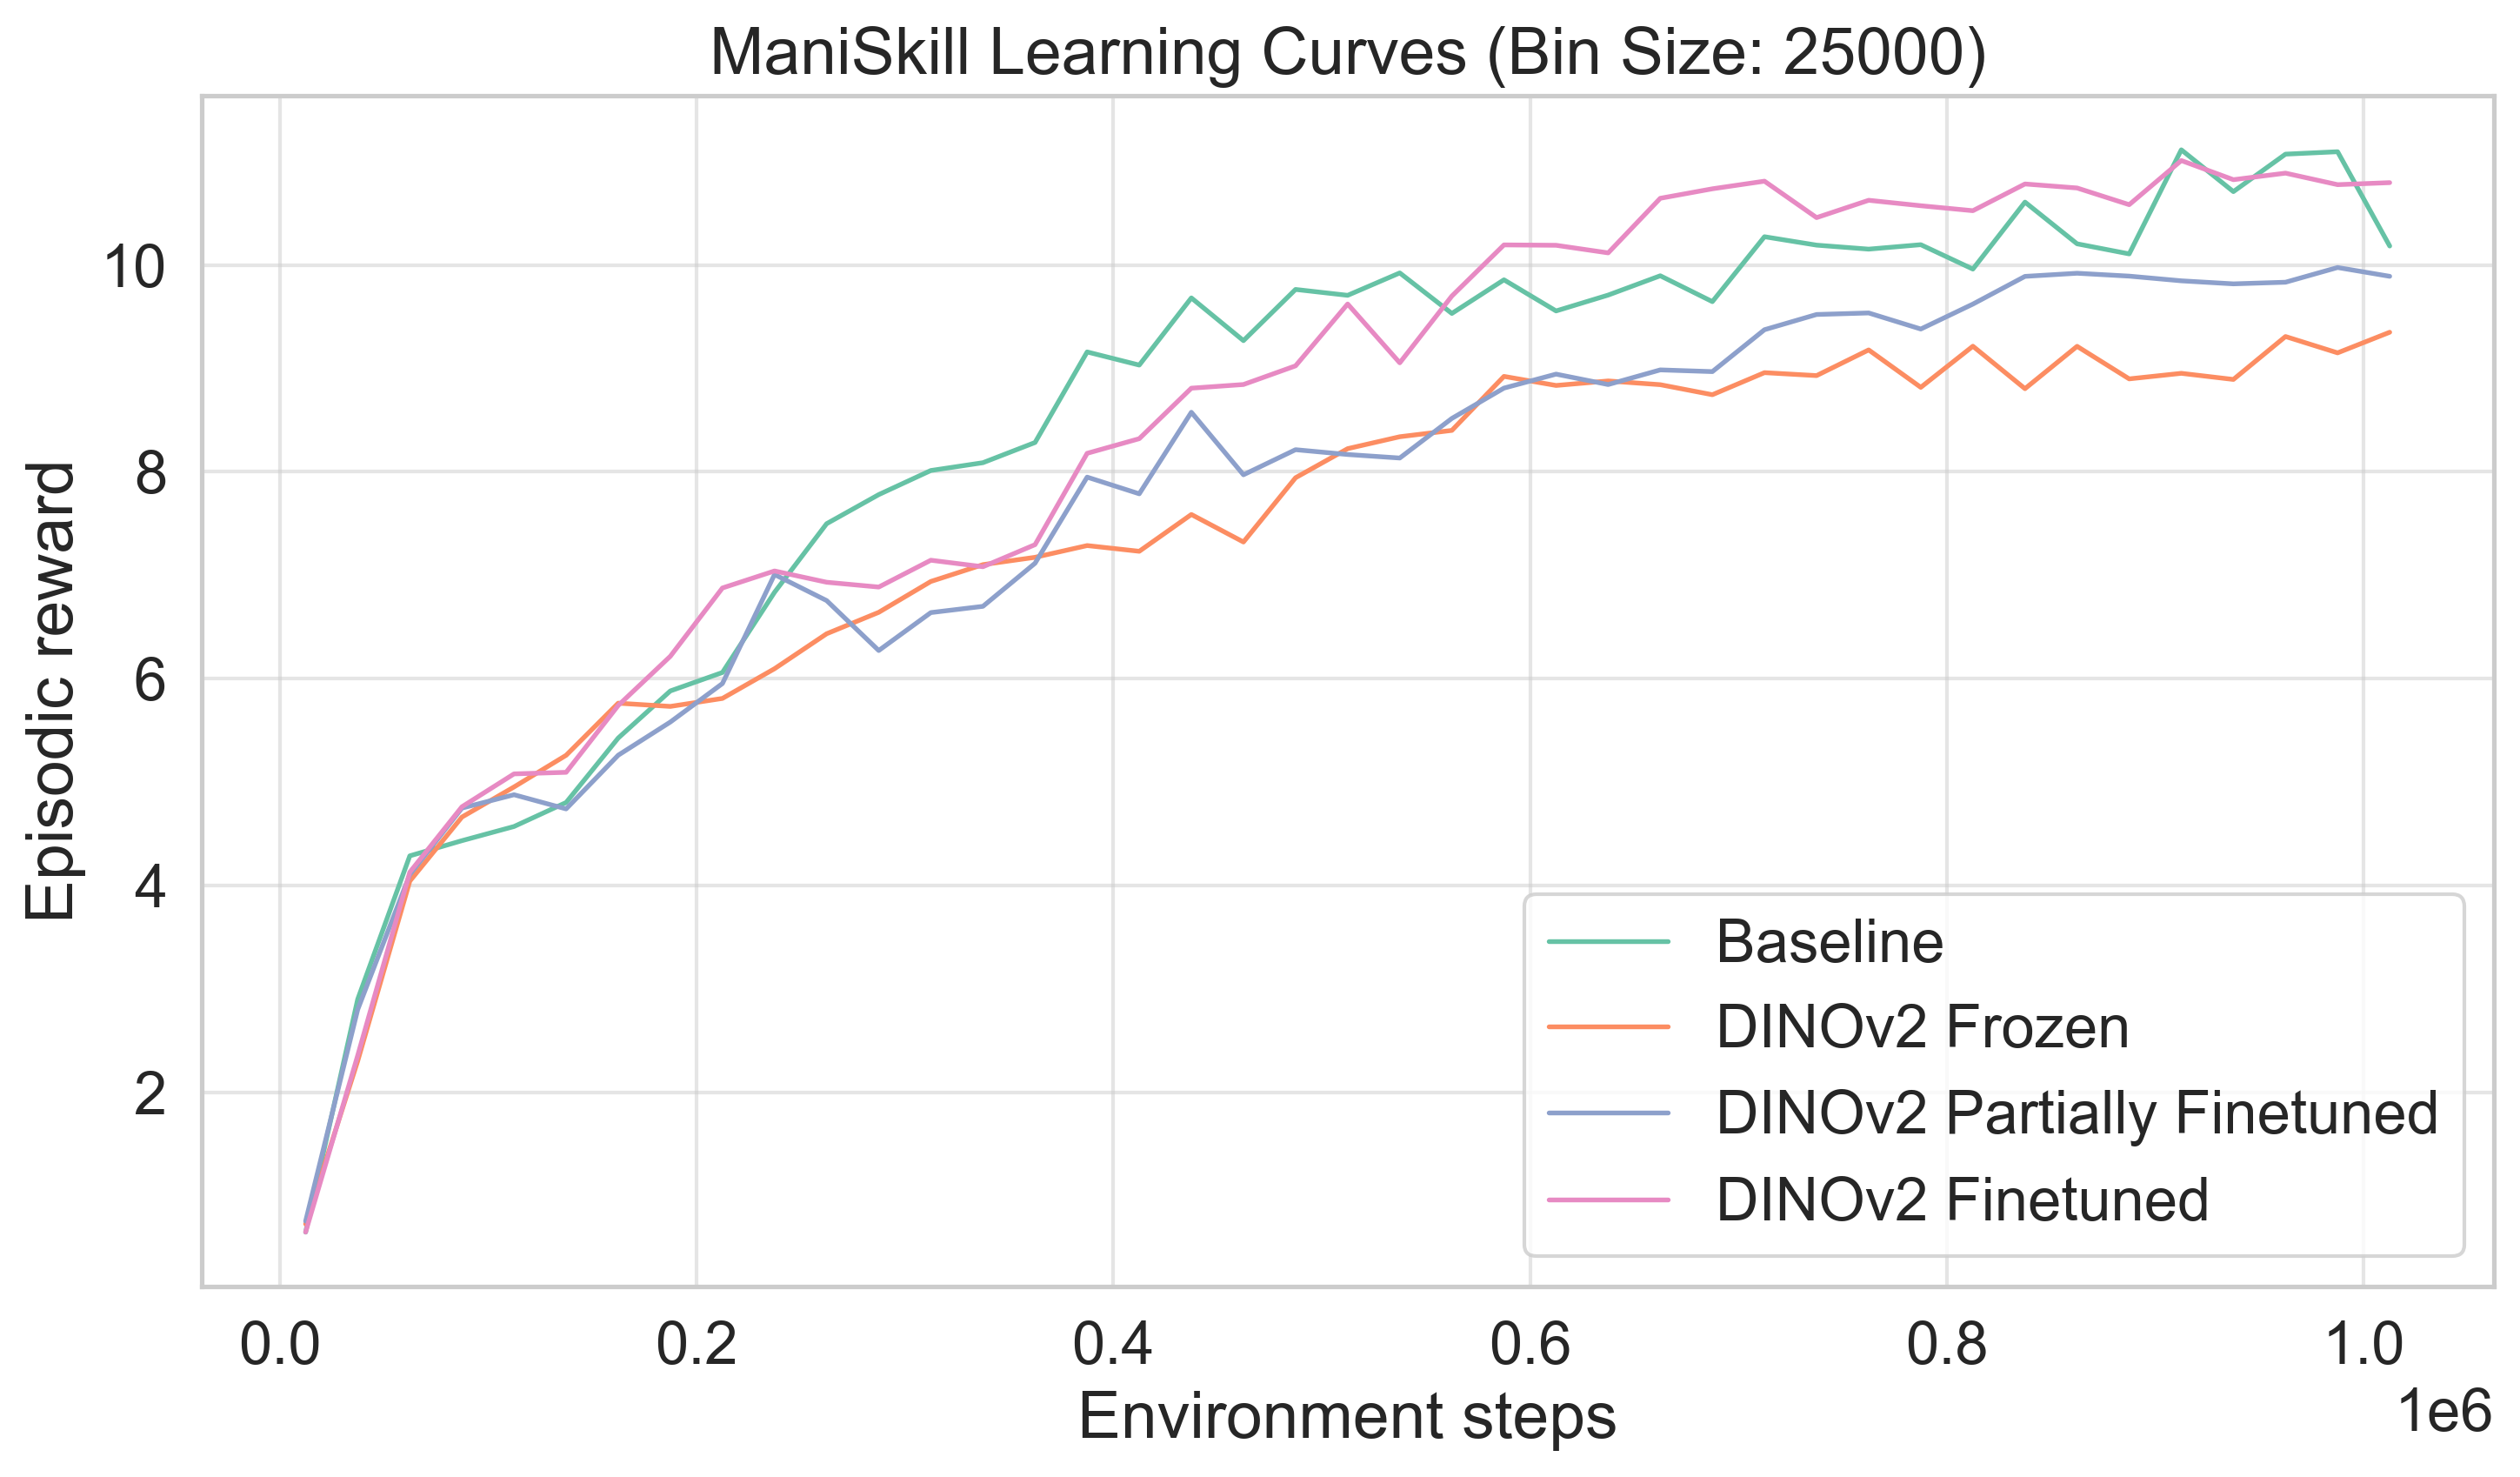

In [63]:
plot(
    files_labels=[
        ("./logdir/PICK_YCB/BASELINE/baseline_pick_ycb_train_ID/scores.jsonl", "Baseline"),
        ("./logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_train_ID/scores.jsonl", "DINOv2 Frozen"),
        ("./logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_train_ID/scores.jsonl", "DINOv2 Partially Finetuned"),
        ("./logdir/PICK_YCB/DINO/DINOFT_pick_ycb_train_ID/scores.jsonl", "DINOv2 Finetuned"),
    ],
    bin_size=25000,
    value_col="episode/score",
    value_name="reward",
    xlabel="Environment steps",
    ylabel="Episodic reward",
    title="ManiSkill Learning Curves",
)

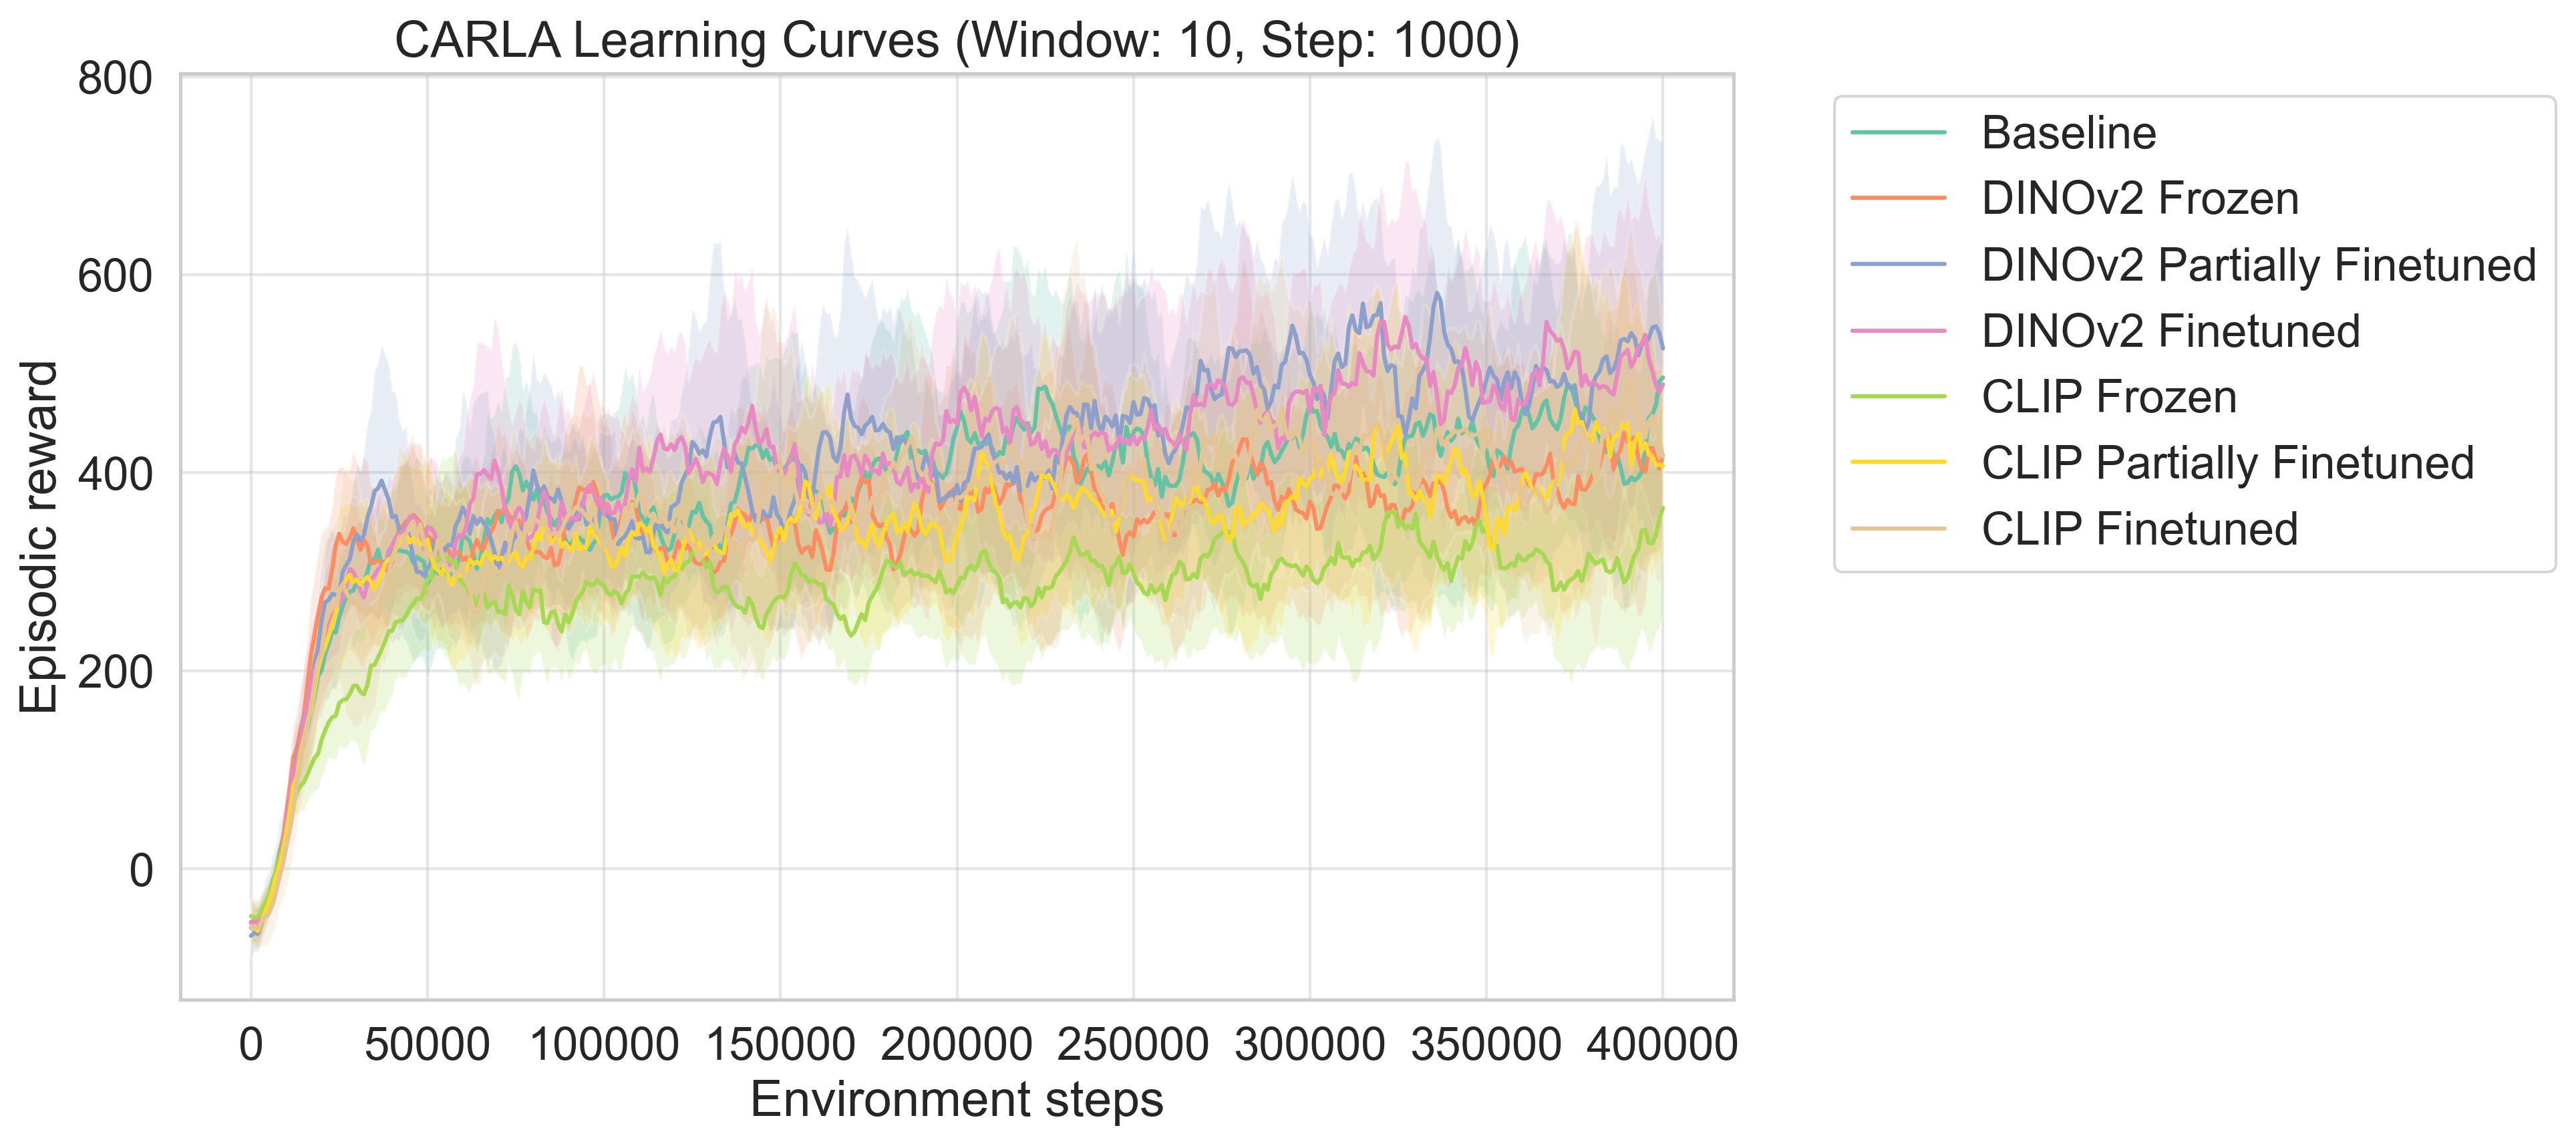

In [65]:
plot_with_uncertainty_interp(
    files_labels_groups=[
        {
            "files": [
                "./logdir/CARLA/BASELINE/baseline_carla_train_ID/scores.jsonl", 
                "./logdir/CARLA/BASELINE/baseline_carla_train_ID_1/scores.jsonl", 
                "./logdir/CARLA/BASELINE/baseline_carla_train_ID_2/scores.jsonl"
            ], 
            "label": "Baseline"
        },
        {
            "files": [
                "./logdir/CARLA/DINO/DINOFreeze_carla_train_ID/scores.jsonl",
                "./logdir/CARLA/DINO/DINOFreeze_carla_train_ID_1/scores.jsonl",
                "./logdir/CARLA/DINO/DINOFreeze_carla_train_ID_2/scores.jsonl"
            ], 
            "label": "DINOv2 Frozen"
        },
        {
            "files": [
                "./logdir/CARLA/DINO/DINOPartial_carla_train_ID/scores.jsonl",
                "./logdir/CARLA/DINO/DINOPartial_carla_train_ID_1/scores.jsonl",
                "./logdir/CARLA/DINO/DINOPartial_carla_train_ID_2/scores.jsonl"
            ], 
            "label": "DINOv2 Partially Finetuned"
        },
        {
            "files": [
                "./logdir/CARLA/DINO/DINOFT_carla_train_ID/scores.jsonl", 
                "./logdir/CARLA/DINO/DINOFT_carla_train_ID_1/scores.jsonl", 
                "./logdir/CARLA/DINO/DINOFT_carla_train_ID_2/scores.jsonl", 
            ], 
            "label": "DINOv2 Finetuned"
        },
        {
            "files": [
                "./logdir/CARLA/CLIP/CLIPFreeze_carla_train_ID/scores.jsonl",
                "./logdir/CARLA/CLIP/CLIPFreeze_carla_train_ID_1/scores.jsonl",
                "./logdir/CARLA/CLIP/CLIPFreeze_carla_train_ID_2/scores.jsonl"
            ], 
            "label": "CLIP Frozen"
        },
        {
            "files": [
                "./logdir/CARLA/CLIP/CLIPPartial_carla_train_ID/scores.jsonl",
                "./logdir/CARLA/CLIP/CLIPPartial_carla_train_ID_1/scores.jsonl",
                "./logdir/CARLA/CLIP/CLIPPartial_carla_train_ID_2/scores.jsonl"
            ], 
            "label": "CLIP Partially Finetuned"
        },
        {
            "files": [
                "./logdir/CARLA/CLIP/CLIPFT_carla_train_ID/scores.jsonl", 
                "./logdir/CARLA/CLIP/CLIPFT_carla_train_ID_1/scores.jsonl", 
                "./logdir/CARLA/CLIP/CLIPFT_carla_train_ID_2/scores.jsonl", 
            ], 
            "label": "CLIP Finetuned"
        },
    ],
    window=10,
    max_step=400_000,
    value_col="episode/score",
    value_name="reward",
    xlabel="Environment steps",
    ylabel="Episodic reward",
    title="CARLA Learning Curves",
)

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_69274/950051003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_69274/950051003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df["step"], bins))
/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_69274/950051003.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

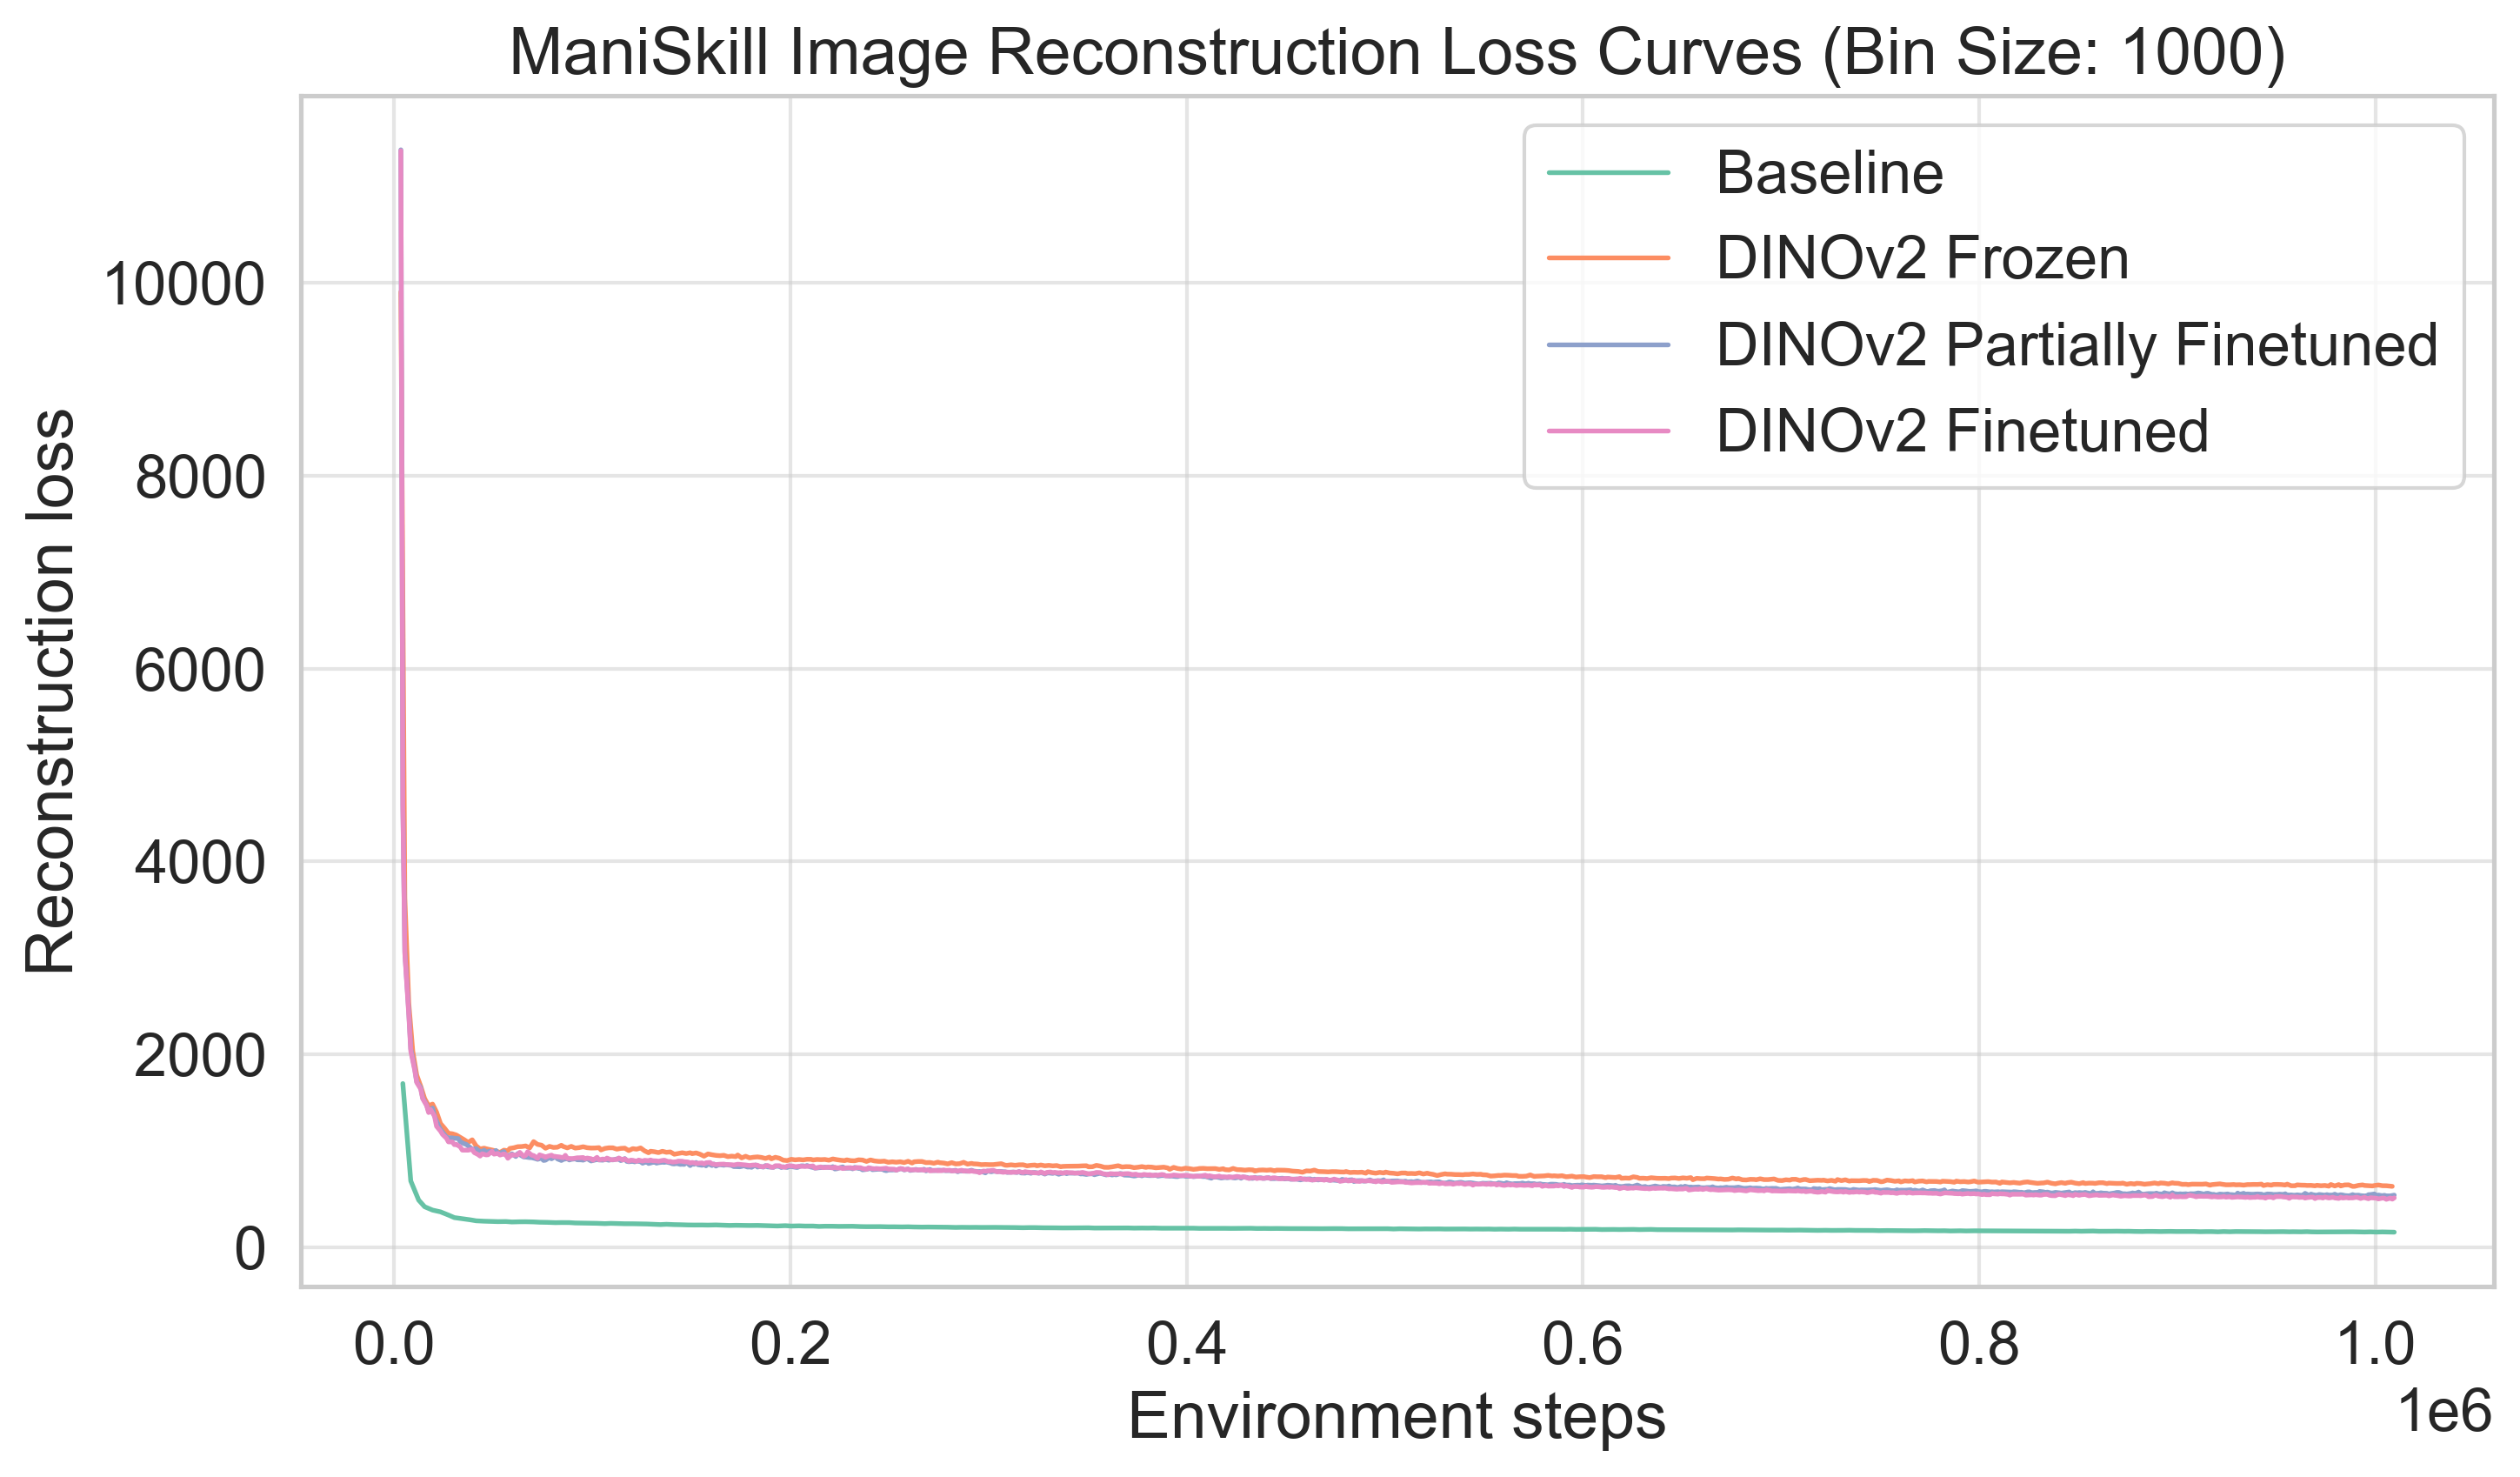

In [ ]:
plot(
    files_labels=[
        ("./logdir/baseline_pick_ycb_train_ID/", "Baseline"),
        ("./logdir/DINOFreeze_pick_ycb_train_ID/", "DINOv2 Frozen"),
        ("./logdir/DINOPartial_pick_ycb_train_ID/", "DINOv2 Partially Finetuned"),
        ("./logdir/DINOFT_pick_ycb_train_ID/", "DINOv2 Finetuned"),
    ],
    bin_size=1000,
    value_col="train/loss/image",
    value_name="image_loss",
    xlabel="Environment steps",
    ylabel="Reconstruction loss",
    title="ManiSkill Image Reconstruction Loss Curves",
)